# Monk's Problem

Import our own neural network code aswell as numpy and pandas for data handling and loading.

In [1]:
import numpy as np
import pandas as pd
from network import *
from train_utils import *
from tqdm import tqdm
import matplotlib.pyplot as plt

Read the data into pandas dataframes, remove empty first column, remove ids, split into variables and class labels.

In [2]:
X1_df = pd.read_csv("data/monks/monks-1.train", sep=" ", header=None)
XT1_df = pd.read_csv("data/monks/monks-1.test", sep=" ", header=None)
X2_df = pd.read_csv("data/monks/monks-2.train", sep=" ", header=None)
XT2_df = pd.read_csv("data/monks/monks-2.test", sep=" ", header=None)
X3_df = pd.read_csv("data/monks/monks-3.train", sep=" ", header=None)
XT3_df = pd.read_csv("data/monks/monks-3.test", sep=" ", header=None)

Y1_df = X1_df.pop(1)
X1_df = X1_df.drop(columns=[0, 8])
YT1_df = XT1_df.pop(1)
XT1_df = XT1_df.drop(columns=[0, 8])
Y2_df = X2_df.pop(1)
X2_df = X2_df.drop(columns=[0, 8])
YT2_df = XT2_df.pop(1)
XT2_df = XT2_df.drop(columns=[0, 8])
Y3_df = X3_df.pop(1)
X3_df = X3_df.drop(columns=[0, 8])
YT3_df = XT3_df.pop(1)
XT3_df = XT3_df.drop(columns=[0, 8])

print(X1_df.shape)
print(X1_df.head())
print(Y1_df.shape)
print(Y1_df.head())

(124, 6)
   2  3  4  5  6  7
0  1  1  1  1  3  1
1  1  1  1  1  3  2
2  1  1  1  3  2  1
3  1  1  1  3  3  2
4  1  1  2  1  2  1
(124,)
0    1
1    1
2    1
3    1
4    1
Name: 1, dtype: int64


Apply one-hot encoding to each variable and convert to numpy arrays.

In [3]:
def one_hot_encode_feature(df, feature_to_encode):
    dummies = pd.get_dummies(df[feature_to_encode], dtype="int32", prefix=feature_to_encode)
    result_df = pd.concat([df, dummies], axis=1)
    return result_df.drop(columns=feature_to_encode)

for feature in X1_df.columns:
    X1_df = one_hot_encode_feature(X1_df, feature)
    XT1_df = one_hot_encode_feature(XT1_df, feature)
    X2_df = one_hot_encode_feature(X2_df, feature)
    XT2_df = one_hot_encode_feature(XT2_df, feature)
    X3_df = one_hot_encode_feature(X3_df, feature)
    XT3_df = one_hot_encode_feature(XT3_df, feature)

X1 = X1_df.to_numpy()
Y1 = Y1_df.to_numpy().reshape(-1, 1)
XT1 = XT1_df.to_numpy()
YT1 = YT1_df.to_numpy().reshape(-1, 1)
X2 = X2_df.to_numpy()
Y2 = Y2_df.to_numpy().reshape(-1, 1)
XT2 = XT2_df.to_numpy()
YT2 = YT2_df.to_numpy().reshape(-1, 1)
X3 = X3_df.to_numpy()
Y3 = Y3_df.to_numpy().reshape(-1, 1)
XT3 = XT3_df.to_numpy()
YT3 = YT3_df.to_numpy().reshape(-1, 1)
print(X1.shape)
print(Y1.shape)
print(X1)

(124, 17)
(124, 1)
[[1 0 0 ... 0 1 0]
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 1 0]
 ...
 [0 0 1 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 [0 0 1 ... 1 0 1]]


## Initial Training
We first train with hould-out validation and hold-out test to see if training works at all.

Split data into train and validation sets, using 80% of the data for train and 20% for validation. The test set is already given as part of the dataset.

In [4]:
def split_data(X, Y, train_fraction=0.8, shuffle=True):
    n = X.shape[0]
    indices = np.arange(n)
    if shuffle:
        np.random.shuffle(indices)

    train_size = int(n * train_fraction)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    return X_train, Y_train, X_test, Y_test

XTr1, YTr1, XVl1, YVl1 = split_data(X1, Y1)
XTr2, YTr2, XVl2, YVl2 = split_data(X2, Y2)
XTr3, YTr3, XVl3, YVl3 = split_data(X3, Y3)

print(XTr1.shape, YTr1.shape, XVl1.shape, YVl1.shape)

(99, 17) (99, 1) (25, 17) (25, 1)


Define datasets and dataloaders.

In [5]:
XTr1_dl = DataLoader(Dataset(XTr1, YTr1), batch_size=8, shuffle=True)
XTr2_dl = DataLoader(Dataset(XTr2, YTr2), batch_size=8, shuffle=True)
XTr3_dl = DataLoader(Dataset(XTr3, YTr3), batch_size=8, shuffle=True)
XVl1_dl = DataLoader(Dataset(XVl1, YVl1), batch_size=8, shuffle=False)
XVl2_dl = DataLoader(Dataset(XVl2, YVl2), batch_size=8, shuffle=False)
XVl3_dl = DataLoader(Dataset(XVl3, YVl3), batch_size=8, shuffle=False)
XT1_dl = DataLoader(Dataset(XT1, YT1), batch_size=8, shuffle=False)
XT2_dl = DataLoader(Dataset(XT2, YT2), batch_size=8, shuffle=False)
XT3_dl = DataLoader(Dataset(XT3, YT3), batch_size=8, shuffle=False)

Train a small model to see if training works at all.

In [6]:
model = Model(
    LinearLayer(17, 3),
    ReLU(),
    LinearLayer(3, 1),
    Sigmoid(),
)
loss_fn = BCELoss()
optimizer = AdamWOptimizer(model, learning_rate=0.01, weight_decay=0.01)



for epoch in range(25):
    # Train
    train_total_n = 0
    train_losses = 0.0
    train_correct_n = 0
    for x_batch, y_batch in XTr1_dl:
        y_pred = model.forward(x_batch)
        loss = loss_fn.forward(y_pred, y_batch)
        grad_loss = loss_fn.backward()
        model.backward(grad_loss)
        optimizer.step()
        train_total_n += y_batch.shape[0]
        train_losses += loss * y_batch.shape[0]
        y_hat = (y_pred >= 0.5).astype(int)
        train_correct_n += np.sum(y_hat == y_batch)

    # Validate
    val_total_n = 0
    val_losses = 0.0
    val_correct_n = 0
    for x_batch, y_batch in XVl1_dl:
        y_pred = model.forward(x_batch)
        loss = loss_fn.forward(y_pred, y_batch)
        val_total_n += y_batch.shape[0]
        val_losses += loss * y_batch.shape[0]
        y_hat = (y_pred >= 0.5).astype(int)
        val_correct_n += np.sum(y_hat == y_batch)

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_losses / train_total_n:.4f} | Train Acc: {train_correct_n / train_total_n:.4f} | Val Loss: {val_losses / val_total_n:.4f} | Val Acc: {val_correct_n / val_total_n:.4f}")

Epoch 001 | Train Loss: 0.7017 | Train Acc: 0.5758 | Val Loss: 0.6917 | Val Acc: 0.5200
Epoch 002 | Train Loss: 0.6740 | Train Acc: 0.6364 | Val Loss: 0.6856 | Val Acc: 0.5200
Epoch 003 | Train Loss: 0.6528 | Train Acc: 0.6768 | Val Loss: 0.6773 | Val Acc: 0.6000
Epoch 004 | Train Loss: 0.6263 | Train Acc: 0.6869 | Val Loss: 0.6478 | Val Acc: 0.6800
Epoch 005 | Train Loss: 0.5904 | Train Acc: 0.7273 | Val Loss: 0.6202 | Val Acc: 0.7200
Epoch 006 | Train Loss: 0.5526 | Train Acc: 0.7374 | Val Loss: 0.5710 | Val Acc: 0.8000
Epoch 007 | Train Loss: 0.5093 | Train Acc: 0.7071 | Val Loss: 0.5399 | Val Acc: 0.7600
Epoch 008 | Train Loss: 0.4666 | Train Acc: 0.7778 | Val Loss: 0.5207 | Val Acc: 0.8000
Epoch 009 | Train Loss: 0.4306 | Train Acc: 0.8081 | Val Loss: 0.4969 | Val Acc: 0.8400
Epoch 010 | Train Loss: 0.4040 | Train Acc: 0.8182 | Val Loss: 0.4851 | Val Acc: 0.8400
Epoch 011 | Train Loss: 0.3806 | Train Acc: 0.8182 | Val Loss: 0.4877 | Val Acc: 0.8400
Epoch 012 | Train Loss: 0.3700 |

In [7]:
# Test
total_n = 0
test_losses = 0.0
correct_n = 0
for x_batch, y_batch in XT1_dl:
    y_pred = model.forward(x_batch)
    loss = loss_fn.forward(y_pred, y_batch)
    total_n += y_batch.shape[0]
    test_losses += loss * y_batch.shape[0]
    y_hat = (y_pred >= 0.5).astype(int)
    correct_n += np.sum(y_hat == y_batch)

print(f"Test Loss: {test_losses / total_n:.4f} | Test Acc: {correct_n / total_n:.4f}")

Test Loss: 0.4549 | Test Acc: 0.7685


## Cross Validation + Grid Search
Now that we have a basic model that is able to learn, we do a cross validation with grid search and hold out the test set each time (because the test set was already separated as part of the Monk's problems).

The relevant functions are in `train_utils.py`.


In [8]:
parameters = dict(
    learning_rates = [0.001, 0.005, 0.01, 0.05],
    weight_decays = [0.001, 0.005, 0.01, 0.05],
    input_size = 17,
    hidden_units_layer_1 = [3, 4, 5, 6],
    hidden_units_layer_2 = [0, 2, 3, 4, 5, 6],
    hidden_units_layer_3 = [0],
    output_size = 1,
    batch_sizes = [8],
    activations_hidden_layer = [ReLU],
    activations_output_layer = [Sigmoid],
    loss_functions = [BCELoss],
    optimizers = [AdamWOptimizer],
)

cfgs = generate_param_cfgs(parameters)
print(len(cfgs))
print(cfgs[0])

384
{'learning_rate': 0.001, 'weight_decay': 0.001, 'input_size': 17, 'hidden_units_layer_1': 3, 'hidden_units_layer_2': 0, 'hidden_units_layer_3': 0, 'batch_size': 8, 'output_size': 1, 'activation_hidden_layer': <class 'network.relu.ReLU'>, 'activation_output_layer': <class 'network.sigmoid.Sigmoid'>, 'loss_function': <class 'network.bce.BCELoss'>, 'optimizer': <class 'network.adam.AdamWOptimizer'>}


First Monk 1, then 2 and 3.

In [9]:
results1 = grid_search_cross_validate(X1, Y1, cfgs, final_metric_fn=accuracy)
best_cfg1, best_result1, epochs1 = max(results1, key=lambda x: x[1])
print("Best config:", best_cfg1)
print(f"Best validation acc: {best_result1:.4f}")
print(f"Used epochs: {epochs1}")

100%|██████████| 384/384 [05:15<00:00,  1.22it/s]

Best config: {'learning_rate': 0.01, 'weight_decay': 0.001, 'input_size': 17, 'hidden_units_layer_1': 5, 'hidden_units_layer_2': 2, 'hidden_units_layer_3': 0, 'batch_size': 8, 'output_size': 1, 'activation_hidden_layer': <class 'network.relu.ReLU'>, 'activation_output_layer': <class 'network.sigmoid.Sigmoid'>, 'loss_function': <class 'network.bce.BCELoss'>, 'optimizer': <class 'network.adam.AdamWOptimizer'>}
Best validation acc: 0.6063
Used epochs: 31


Retrain best found parameters on train + validation set, then assess performance on test set. Repeat n times and average results, because dataset is very small and initialization matters.

Test Loss: 0.1299 | Test Acc: 0.9977


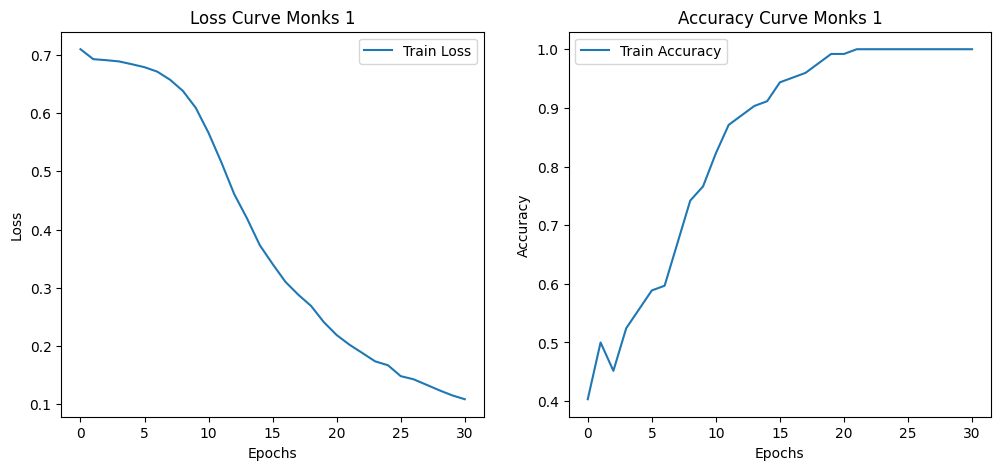

In [10]:
X1_dl = DataLoader(Dataset(X1, Y1), batch_size=best_cfg1['batch_size'], shuffle=False)

best_model1 = create_model(best_cfg1)
loss_fn = best_cfg1['loss_function']()
optimizer = best_cfg1['optimizer'](best_model1, learning_rate=best_cfg1['learning_rate'], weight_decay=best_cfg1['weight_decay'])
# Train on full training data
best_model1, _, _, curves1 = train_model(best_model1, loss_fn, optimizer, X1_dl, None, accuracy, max_epochs=epochs1)

# Test on test data
test_loss1, test_acc1 = epoch_run(best_model1, loss_fn, None, XT1_dl, accuracy, update_weights=False)
print(f"Test Loss: {test_loss1:.4f} | Test Acc: {test_acc1:.4f}")

# Plot only train loss and accuracy curves since we dont have validation data here
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(curves1['train_loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve Monks 1')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(curves1['train_final_metric'], label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve Monks 1')
plt.legend()
plt.show()

Monk 2.

In [11]:
results2 = grid_search_cross_validate(X2, Y2, cfgs, final_metric_fn=accuracy)
best_cfg2, best_result2, epochs2 = max(results2, key=lambda x: x[1])
print("Best config:", best_cfg2)
print(f"Best validation acc: {best_result2:.4f}")
print(f"Used epochs: {epochs2}")

100%|██████████| 384/384 [23:17<00:00,  3.64s/it]

Best config: {'learning_rate': 0.01, 'weight_decay': 0.01, 'input_size': 17, 'hidden_units_layer_1': 6, 'hidden_units_layer_2': 5, 'hidden_units_layer_3': 0, 'batch_size': 8, 'output_size': 1, 'activation_hidden_layer': <class 'network.relu.ReLU'>, 'activation_output_layer': <class 'network.sigmoid.Sigmoid'>, 'loss_function': <class 'network.bce.BCELoss'>, 'optimizer': <class 'network.adam.AdamWOptimizer'>}
Best validation acc: 1.0000
Used epochs: 179


Test Loss: 0.0001 | Test Acc: 1.0000


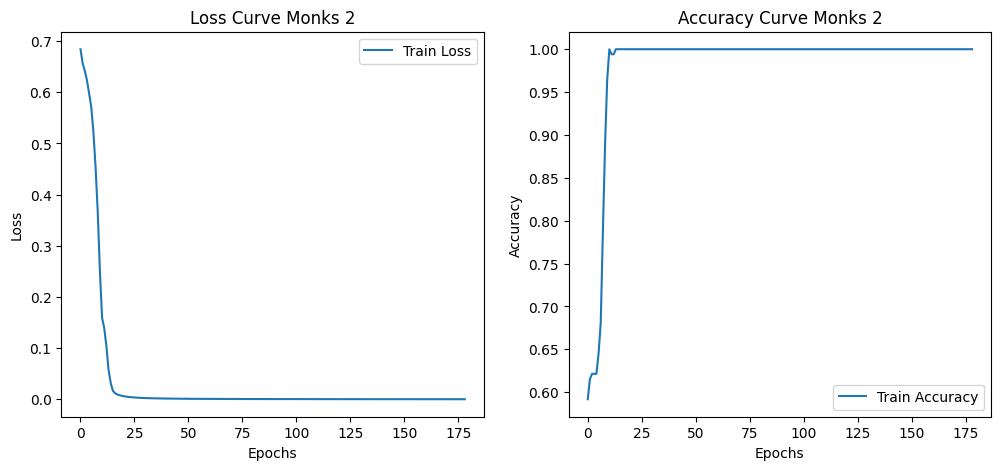

In [12]:
X2_dl = DataLoader(Dataset(X2, Y2), batch_size=best_cfg2['batch_size'], shuffle=False)

best_model2 = create_model(best_cfg2)
loss_fn = best_cfg2['loss_function']()
optimizer = best_cfg2['optimizer'](best_model2, learning_rate=best_cfg2['learning_rate'], weight_decay=best_cfg2['weight_decay'])
# Train on full training data
best_model2, _, _, curves2 = train_model(best_model2, loss_fn, optimizer, X2_dl, None, accuracy, max_epochs=epochs2)

# Test on test data
test_loss2, test_acc2 = epoch_run(best_model2, loss_fn, None, XT2_dl, accuracy, update_weights=False)
print(f"Test Loss: {test_loss2:.4f} | Test Acc: {test_acc2:.4f}")

# Plot only train loss and accuracy curves since we dont have validation data here
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(curves2['train_loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve Monks 2')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(curves2['train_final_metric'], label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve Monks 2')
plt.legend()
plt.show()

Monk 3.

In [13]:
results3 = grid_search_cross_validate(X3, Y3, cfgs, final_metric_fn=accuracy)
best_cfg3, best_result3, epochs3 = max(results3, key=lambda x: x[1])
print("Best config:", best_cfg3)
print(f"Best validation acc: {best_result3:.4f}")
print(f"Used epochs: {epochs3}")

100%|██████████| 384/384 [08:59<00:00,  1.40s/it]

Best config: {'learning_rate': 0.01, 'weight_decay': 0.05, 'input_size': 17, 'hidden_units_layer_1': 4, 'hidden_units_layer_2': 3, 'hidden_units_layer_3': 0, 'batch_size': 8, 'output_size': 1, 'activation_hidden_layer': <class 'network.relu.ReLU'>, 'activation_output_layer': <class 'network.sigmoid.Sigmoid'>, 'loss_function': <class 'network.bce.BCELoss'>, 'optimizer': <class 'network.adam.AdamWOptimizer'>}
Best validation acc: 0.9373
Used epochs: 33


Test Loss: 0.1318 | Test Acc: 0.9514


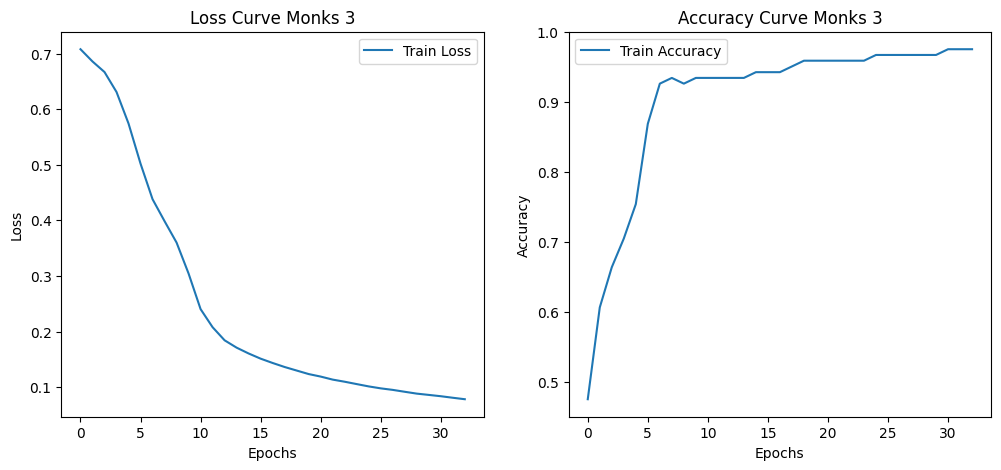

In [14]:
X3_dl = DataLoader(Dataset(X3, Y3), batch_size=best_cfg3['batch_size'], shuffle=False)

best_model3 = create_model(best_cfg3)
loss_fn = best_cfg3['loss_function']()
optimizer = best_cfg3['optimizer'](best_model3, learning_rate=best_cfg3['learning_rate'], weight_decay=best_cfg3['weight_decay'])
# Train on full training data
best_model3, _, _, curves3 = train_model(best_model3, loss_fn, optimizer, X3_dl, None, accuracy, max_epochs=epochs3)

# Test on test data
test_loss3, test_acc3 = epoch_run(best_model3, loss_fn, None, XT3_dl, accuracy, update_weights=False)
print(f"Test Loss: {test_loss3:.4f} | Test Acc: {test_acc3:.4f}")

# Plot only train loss and accuracy curves since we dont have validation data here
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(curves3['train_loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve Monks 3')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(curves3['train_final_metric'], label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve Monks 3')
plt.legend()
plt.show()